# SCEPTR High-Weight TCR Analysis

In this notebook, we do the following:
1. Load a chosen SCEPTR model checkpoint (best epoch) from one run.
2. For **each** control and cancer patient, compute the attention weights for **every** TCR in that patient's repertoire.
3. Extract the **top K** TCRs by weight.
4. Count how frequently each TCR appears in top K among cancer vs. control patients.

Finally, we show a table or two that might reveal TCR sequences commonly flagged as "high weight" in multiple cancer patients but not in controls.

In [21]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

from src.model import sceptr_unidirectional, load_trained
import sceptr

plt.rcParams["figure.figsize"] = (12, 8)
sns.set_style("whitegrid")

print("Imports done.")

Imports done.


## 1. Configuration
- Choose the run index and best epoch.
- Define paths to your `control` and `pbmc_cancer` directories.
- We also define `TOP_K` = 10 (or whichever value you like).

In [22]:
BEST_RUN_INDEX = 0  # e.g. run 0
BEST_EPOCH = 33     # e.g. epoch 33

TOP_K = 10  # how many top TCRs we extract from each patient

base_dir = Path.cwd() / "results-new-beta" / "sceptr"
model_dir = base_dir / f"trained-sceptr-{BEST_RUN_INDEX}" / f"Epoch {BEST_EPOCH}"
model_path = model_dir / f"classifier-{BEST_EPOCH}.pth"

# The data directories:
eval_dir = Path.cwd() / "data" / "beta" / "sceptr-eval"
control_dir = eval_dir / "control"
cancer_dir = eval_dir / "pbmc_cancer"

print("Model path:", model_path)
print("Control dir:", control_dir)
print("Cancer dir:", cancer_dir)

Model path: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/results-new-beta/sceptr/trained-sceptr-0/Epoch 33/classifier-33.pth
Control dir: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/data/beta/sceptr-eval/control
Cancer dir: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/data/beta/sceptr-eval/pbmc_cancer


## 2. Load Model
We'll load the `sceptr_unidirectional` model with the checkpoint we chose.

In [23]:
model = load_trained(model_path, sceptr_unidirectional)
model.eval()
if torch.cuda.is_available():
    model.cuda()
print("Model loaded.")

Model loaded.


## 3. Helper: Get TCR Weights
We define a function that, given a DataFrame of TCR sequences, runs them through the SCEPTR model to get the attention weights for each TCR.  Then we can identify the top K.

We'll also store the TCR's row data so we can see the actual CDR3 or other info.

In [24]:
import torch
import numpy as np

def get_tcr_weights_for_patient(df: pd.DataFrame, model: sceptr_unidirectional):
    """
    Given the TCR DataFrame, returns a DataFrame with columns:
      [ index_of_tcr, cdr3, weight, (optionally other columns from df) ]
    for each TCR in the patient's repertoire.

    We'll use model.last_weights after a forward pass.
    """
    # Step 1: embeddings
    embeddings = sceptr.calc_vector_representations(df)
    embeddings_t = torch.tensor(embeddings, dtype=torch.float32)
    if torch.cuda.is_available():
        embeddings_t = embeddings_t.cuda()

    # Step 2: forward pass
    with torch.no_grad():
        _ = model(embeddings_t)  # triggers model.last_weights
        weights = model.last_weights.detach().cpu().numpy().flatten()

    # We'll assume df has a 'junction_aa' or some CDR3 column.
    # If your column is differently named, adjust it.
    cdr3_col = 'CDR3B'
    if cdr3_col not in df.columns:
        # fallback if data doesn't have 'junction_aa'
        cdr3_col = df.columns[0]  # or something

    # Build a small result DataFrame:
    out_df = df.copy()
    out_df['__weight__'] = weights
    out_df['__index__'] = range(len(out_df))
    return out_df

## 4. Process All Patients
We’ll loop over `control/*.tsv` and `pbmc_cancer/*.tsv`.  For each file (patient), we:
1. Compute TCR weights.
2. Sort descending by weight.
3. Take the top K TCRs.
4. Collect them in a list.  Each record will have the TCR's sequence, weight, whether it’s from cancer or control, etc.


In [25]:
control_files = sorted(control_dir.glob("*.tsv"))
cancer_files = sorted(cancer_dir.glob("*.tsv"))

records = []  # will store dicts of e.g. { 'tcr': x, 'weight': y, 'label': 0/1, 'patient_id': ??? }

def process_patient_tcrs(file_path: Path, label: int, top_k=10):
    """
    label=0 => control, label=1 => cancer.
    Returns a list of dicts for the top K TCRs.
    """
    df = pd.read_csv(file_path, sep="\t")
    weights_df = get_tcr_weights_for_patient(df, model)

    # Sort by weight descending
    weights_df = weights_df.sort_values(by="__weight__", ascending=False)
    top_df = weights_df.head(top_k)

    results = []
    for _, row in top_df.iterrows():
        # We'll store cdr3 sequence, weight, label, patient
        rec = {
            'tcr': row.get('CDR3B', 'unknown'),
            'weight': row['__weight__'],
            'label': label,
            'patient_id': file_path.stem
        }
        results.append(rec)

    return results

# Go through control and cancer patients
for f in tqdm(control_files):
    recs = process_patient_tcrs(f, label=0, top_k=TOP_K)
    records.extend(recs)

for f in tqdm(cancer_files):
    recs = process_patient_tcrs(f, label=1, top_k=TOP_K)
    records.extend(recs)

df_top = pd.DataFrame(records)
print(f"Number of top TCR records = {len(df_top)}")
df_top.head(10)

100%|██████████| 11/11 [00:07<00:00,  1.39it/s]

Number of top TCR records = 330


,tcr,weight,label,patient_id
0,CASSFPPRHAGPSLGYEQYF,0.086045,0,dcr_UP_0318_1_beta
1,CASSERSGSGRDSYNEQFF,0.078771,0,dcr_UP_0318_1_beta
2,CASSYALHTSGEPQETQYF,0.075794,0,dcr_UP_0318_1_beta
3,CASSPRSVREGLAGLETQYF,0.070160,0,dcr_UP_0318_1_beta
4,CASSYALAGGPDHYEQYF,0.064058,0,dcr_UP_0318_1_beta
5,CASSSHGERGGPRETQYF,0.056271,0,dcr_UP_0318_1_beta
6,CASSEESWGQGPPFEETQYF,0.054613,0,dcr_UP_0318_1_beta
7,CASSWEPGQGTDEETQYF,0.041387,0,dcr_UP_0318_1_beta
8,CASSSHGERGGPRDTQYF,0.039429,0,dcr_UP_0318_1_beta
9,CASSLYEGFGGLSGNTIYF,0.038488,0,dcr_UP_0318_1_beta


## 5. Frequency Analysis
Now we have a DataFrame `df_top`, where each row is a TCR from the top K of some patient.  Let’s see how often each TCR appears in the top K for cancer vs. control.

### 5.1 Groupby TCR
We do a groupby on `tcr` and `label` to see the counts.

In [26]:
grouped = df_top.groupby(["tcr", "label"]).size().reset_index(name="count")
grouped.head(15)

,tcr,label,count
0,CAATEGRGSYEQYF,0,1
1,CACRERHCRGAGGYEQYF,1,1
2,CACSLGGASGHPGETQYF,1,1
3,CACSLMQGGSHEQYF,1,1
4,CAISEALTGDHSYEQYF,1,1
5,CAISEAPPTRDSNHGELFF,1,1
6,CAISERSGTGRSSDTQYF,1,1
7,CAISESAGRGPSTDTQYF,1,1
8,CAISESGTGGSPYEQYF,0,1
9,CAISESPGQVADLYEQYF,0,1


### 5.2 Pivot into wide format
We can pivot so we get columns like `[tcr, count_control, count_cancer]`.


In [27]:
pivoted = grouped.pivot(index="tcr", columns="label", values="count").fillna(0)
pivoted.columns = ["count_control", "count_cancer"]
pivoted = pivoted.sort_values(by="count_cancer", ascending=False)
pivoted.head(20)

,count_control,count_cancer
tcr,,
CASSHSGGLYEQYF,0.0,2.0
CASSYPPATGNSHLGEQYF,0.0,2.0
CASSESSREGRLDTQYF,0.0,2.0
CASSEVRHRGPPNNEQFF,0.0,2.0
CASSLGMARGPRQDTQYF,0.0,2.0
CASSYSVVEGRAPHEQYF,0.0,2.0
CASSLVFGTGGSYNEQFF,0.0,1.0
CASSLQPQNFGLACYNEQFF,0.0,1.0
CASSYPMVGGNPGYSPHEQYF,0.0,1.0


### 5.3 Display TCRs That Appear Frequently in Cancer But Not in Control
We can do something like: only keep TCRs with `count_cancer >= X` and `count_control == 0`, for instance. Or you can do a ratio.


In [28]:
min_cancer_count = 2  # adjust as you like
candidate_tcrs = pivoted[(pivoted["count_cancer"] >= min_cancer_count) & (pivoted["count_control"] == 0)]
print(f"Found {len(candidate_tcrs)} TCRs that appear >= {min_cancer_count} times in cancer but 0 in control.")
candidate_tcrs.head(20)

Found 6 TCRs that appear >= 2 times in cancer but 0 in control.


,count_control,count_cancer
tcr,,
CASSHSGGLYEQYF,0.0,2.0
CASSYPPATGNSHLGEQYF,0.0,2.0
CASSESSREGRLDTQYF,0.0,2.0
CASSEVRHRGPPNNEQFF,0.0,2.0
CASSLGMARGPRQDTQYF,0.0,2.0
CASSYSVVEGRAPHEQYF,0.0,2.0


This table is an example of TCR sequences that the model strongly weights (they appear in the top K for multiple cancer patients) but do **not** appear in control top K.
In principle, these might be interesting TCRs potentially associated with cancer.

Of course, interpret carefully: a TCR might still appear in control patients' repertoires, but just not in the top K.


## 6. Additional Visualizations
You can also do:
- A bar chart of TCR frequencies in cancer vs. control.
- A quick table listing the top 20 TCRs for each.

Below is an example bar chart for the top TCRs in `candidate_tcrs`.


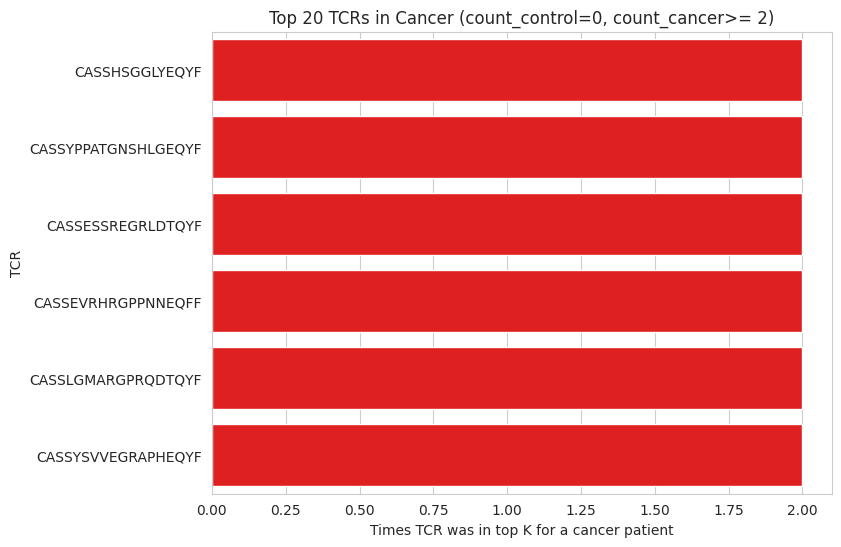

In [29]:
cand_sorted = candidate_tcrs.sort_values("count_cancer", ascending=False).head(20).reset_index()

plt.figure(figsize=(8,6))
sns.barplot(
    data=cand_sorted,
    x="count_cancer",
    y="tcr",
    orient="h",
    color="red"
)
plt.title(f"Top 20 TCRs in Cancer (count_control=0, count_cancer>= {min_cancer_count})")
plt.xlabel("Times TCR was in top K for a cancer patient")
plt.ylabel("TCR")
plt.show()

## 7. Next Steps
- This is just one approach to interpretability. You might also want to do the same for the control group.
- Instead of just top K, you might collect TCRs with weight above some threshold.
- You could also do a more advanced analysis (like see if certain TCRs co-occur across multiple cancer patients).